In [58]:
"""
Step 1 — Scrape Books to Scrape.
Output: data/books_raw.csv
Columns: title, category
"""
import os, time
from urllib.parse import urljoin
import pandas as pd, requests
from bs4 import BeautifulSoup

BASE = "http://books.toscrape.com/"
CATALOG = urljoin(BASE, "catalogue/")
HDRS = {"User-Agent": "Mozilla/5.0"}

def soup(url):
    r = requests.get(url, headers=HDRS, timeout=25); r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def categories():
    s = soup(BASE)
    for a in s.select(".side_categories ul li ul li a"):
        yield a.text.strip(), urljoin(BASE, a["href"])

def parse_card(card):
    title = card.h3.a["title"].strip()
    href  = urljoin(CATALOG, card.h3.a["href"])
    return title, href

def scrape_category(url, name):
    rows = []
    while True:
        s = soup(url)
        for card in s.select("ol.row li.article.product_pod"):
            title, href = parse_card(card)
            rows.append({"title": title, "category": name})
        nxt = s.select_one("li.next a")
        if not nxt: break
        url = urljoin(url, nxt["href"])
        time.sleep(0.25)
    return rows

if __name__ == "__main__":
    os.makedirs("data", exist_ok=True)
    all_rows = []
    for name, href in categories():
        all_rows += scrape_category(href, name)
        time.sleep(0.15)
    df = pd.DataFrame(all_rows).drop_duplicates(subset=["title","category"])
    df.to_csv("data/books_raw.csv", index=False)
    print(f"Saved {len(df)} rows -> data/books_raw.csv")

Saved 0 rows -> data/books_raw.csv


In [59]:
import requests
from bs4 import BeautifulSoup

BASE = "http://books.toscrape.com/"
r = requests.get(BASE, headers={"User-Agent":"Mozilla/5.0"}, timeout=20)
print(r.status_code, len(r.text))
soup = BeautifulSoup(r.text, "html.parser")
cats = soup.select("div.side_categories ul > li > ul > li > a")
print("Found categories:", len(cats))
[a.get_text(strip=True) for a in cats[:5]]

200 51294
Found categories: 50


['Travel', 'Mystery', 'Historical Fiction', 'Sequential Art', 'Classics']

In [60]:
%%writefile scrape_books.py
import os, time
from urllib.parse import urljoin
import requests, pandas as pd
from bs4 import BeautifulSoup

BASE = "http://books.toscrape.com/"
CATALOG = urljoin(BASE, "catalogue/")
HDRS = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64)"}

def get_soup(url):
    r = requests.get(url, headers=HDRS, timeout=25)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def get_categories():
    s = get_soup(BASE)
    # more robust selector for left menu leaf categories
    links = s.select("div.side_categories ul > li > ul > li > a")
    cats = []
    for a in links:
        name = a.get_text(strip=True)
        href = urljoin(BASE, a.get("href"))
        cats.append((name, href))
    return cats

def parse_card(card):
    # robust card parsing
    a = card.select_one("h3 a")
    title = a["title"].strip()
    rel = a["href"]
    href = urljoin(CATALOG, rel)
    return title, href

def scrape_category(url, name, delay=0.25):
    rows, page, total = [], 1, 0
    while True:
        s = get_soup(url)
        cards = s.select("article.product_pod")  # simpler & stable
        for c in cards:
            title, href = parse_card(c)
            rows.append({"title": title, "category": name})
        total += len(cards)
        nxt = s.select_one("li.next a")
        if not nxt: break
        url = urljoin(url, nxt["href"])
        page += 1
        time.sleep(delay)
    print(f"  - {name}: pages={page}, items={total}")
    return rows

if __name__ == "__main__":
    os.makedirs("data", exist_ok=True)
    cats = get_categories()
    print("Categories found:", len(cats))
    if not cats:
        raise RuntimeError("No categories found. Check connection/selectors.")

    all_rows = []
    for i, (name, href) in enumerate(cats, start=1):
        print(f"[{i:02d}] {name}")
        all_rows.extend(scrape_category(href, name))
        time.sleep(0.15)

    df = pd.DataFrame(all_rows).drop_duplicates(subset=["title","category"]).reset_index(drop=True)
    out = "data/books_raw.csv"
    df.to_csv(out, index=False)
    print(f"Saved {len(df)} rows -> {out}")

Overwriting scrape_books.py


In [61]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

BASE = "http://books.toscrape.com/"
CATALOG = urljoin(BASE, "catalogue/")

def test_one_category(url):
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=20)
    soup = BeautifulSoup(r.text, "html.parser")
    cards = soup.select("article.product_pod")
    print("Found cards:", len(cards))
    for c in cards[:3]: 
        a = c.select_one("h3 a")
        print("Title:", a["title"], "| href:", urljoin(CATALOG, a["href"]))

test_one_category("http://books.toscrape.com/catalogue/category/books/travel_2/index.html")

Found cards: 11
Title: It's Only the Himalayas | href: http://books.toscrape.com/its-only-the-himalayas_981/index.html
Title: Full Moon over Noahâs Ark: An Odyssey to Mount Ararat and Beyond | href: http://books.toscrape.com/full-moon-over-noahs-ark-an-odyssey-to-mount-ararat-and-beyond_811/index.html
Title: See America: A Celebration of Our National Parks & Treasured Sites | href: http://books.toscrape.com/see-america-a-celebration-of-our-national-parks-treasured-sites_732/index.html


In [63]:
!python scrape_books.py

Categories found: 50
[01] Travel
  - Travel: 11 books, 1 pages
[02] Mystery
  - Mystery: 32 books, 2 pages
[03] Historical Fiction
  - Historical Fiction: 26 books, 2 pages
[04] Sequential Art
  - Sequential Art: 75 books, 4 pages
[05] Classics
  - Classics: 19 books, 1 pages
[06] Philosophy
  - Philosophy: 11 books, 1 pages
[07] Romance
  - Romance: 35 books, 2 pages
[08] Womens Fiction
  - Womens Fiction: 17 books, 1 pages
[09] Fiction
  - Fiction: 65 books, 4 pages
[10] Childrens
  - Childrens: 29 books, 2 pages
[11] Religion
  - Religion: 7 books, 1 pages
[12] Nonfiction
  - Nonfiction: 110 books, 6 pages
[13] Music
  - Music: 13 books, 1 pages
[14] Default
  - Default: 152 books, 8 pages
[15] Science Fiction
  - Science Fiction: 16 books, 1 pages
[16] Sports and Games
  - Sports and Games: 5 books, 1 pages
[17] Add a comment
  - Add a comment: 67 books, 4 pages
[18] Fantasy
  - Fantasy: 48 books, 3 pages
[19] New Adult
  - New Adult: 6 books, 1 pages
[20] Young Adult
  - Young Adu

In [64]:
import pandas as pd
df = pd.read_csv("data/books_raw.csv")
len(df)
df.head()

,title,category
0,It's Only the Himalayas,Travel
1,Full Moon over Noahâs Ark: An Odyssey to Mou...,Travel
2,See America: A Celebration of Our National Par...,Travel
3,Vagabonding: An Uncommon Guide to the Art of L...,Travel
4,Under the Tuscan Sun,Travel


In [65]:
%%writefile enrich_openlibrary.py
"""
Step 2 — Enrich with Open Library (ONLY title, author, genre).
Input : data/books_raw.csv (columns: title, category)
Output: data/books.csv      (columns: title, author, genre)
"""

import os
import time
import csv
import requests
import pandas as pd
from typing import Optional, Tuple

IN_PATH  = "data/books_raw.csv"
OUT_PATH = "data/books.csv"
CACHE_PATH = "data/ol_cache.csv"   # optional cache to avoid re-querying same titles

HDRS = {"User-Agent": "BookRecsBootcamp/1.0"}
URL  = "https://openlibrary.org/search.json"


def fetch_author_genre(title: str) -> Tuple[Optional[str], Optional[str]]:
    """Query Open Library by title, return (author, genre)."""
    try:
        r = requests.get(URL, params={"title": title, "limit": 3},
                         headers=HDRS, timeout=25)
        r.raise_for_status()
        js = r.json()
        if not js.get("docs"):
            return None, None
        # choose the doc with highest edition_count as a simple quality proxy
        best = max(js["docs"], key=lambda d: d.get("edition_count", 0))
        author = (best.get("author_name") or [None])[0]
        subjects = best.get("subject") or []
        # pick a short subject as genre (fallbacks handled later)
        genre = next((s for s in subjects if isinstance(s, str) and 2 <= len(s) <= 40), None)
        return author, genre
    except Exception:
        return None, None


def load_cache() -> dict:
    if not os.path.exists(CACHE_PATH):
        return {}
    cache = {}
    with open(CACHE_PATH, newline="", encoding="utf-8") as f:
        for row in csv.DictReader(f):
            cache[row["title"]] = (row.get("author") or None, row.get("genre") or None)
    return cache


def save_cache(cache: dict) -> None:
    os.makedirs("data", exist_ok=True)
    with open(CACHE_PATH, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["title", "author", "genre"])
        for t, (a, g) in cache.items():
            w.writerow([t, a or "", g or ""])


if __name__ == "__main__":
    if (not os.path.exists(IN_PATH)) or os.path.getsize(IN_PATH) == 0:
        raise FileNotFoundError("Missing/empty data/books_raw.csv. Run scraping first.")

    raw = pd.read_csv(IN_PATH)
    # Drop obvious dup titles early (keeps first category only)
    titles = raw["title"].astype(str).drop_duplicates().tolist()

    cache = load_cache()
    out_rows = []

    for i, title in enumerate(titles, start=1):
        if title in cache:
            author, genre = cache[title]
        else:
            author, genre = fetch_author_genre(title)
            cache[title] = (author, genre)
            time.sleep(0.2)  # polite rate limit

        # Fallbacks
        if not genre:
            # if raw had a category for this title, use the first one found
            cat_match = raw.loc[raw["title"] == title, "category"]
            genre = cat_match.iloc[0] if len(cat_match) else "Unknown"
        if not author:
            author = "Unknown"

        out_rows.append({"title": title, "author": author, "genre": genre})

        if i % 25 == 0:
            print(f"Enriched {i}/{len(titles)}")
            save_cache(cache)  # periodic cache save

    # Final save
    df = pd.DataFrame(out_rows)
    os.makedirs("data", exist_ok=True)
    df.to_csv(OUT_PATH, index=False)
    save_cache(cache)
    print(f"Saved {len(df)} rows -> {OUT_PATH}")

Overwriting enrich_openlibrary.py


In [66]:
!python enrich_openlibrary.py

Enriched 25/999
Enriched 50/999
Enriched 75/999
Enriched 100/999
Enriched 125/999
Enriched 150/999
Enriched 175/999
Enriched 200/999
Enriched 225/999
Enriched 250/999
Enriched 275/999
Enriched 300/999
Enriched 325/999
Enriched 350/999
Enriched 375/999
Enriched 400/999
Enriched 425/999
Enriched 450/999
Enriched 475/999
Enriched 500/999
Enriched 525/999
Enriched 550/999
Enriched 575/999
Enriched 600/999
Enriched 625/999
Enriched 650/999
Enriched 675/999
Enriched 700/999
Enriched 725/999
Enriched 750/999
Enriched 775/999
Enriched 800/999
Enriched 825/999
Enriched 850/999
Enriched 875/999
Enriched 900/999
Enriched 925/999
Enriched 950/999
Enriched 975/999
Saved 999 rows -> data/books.csv


In [67]:
import pandas as pd
df = pd.read_csv("data/books.csv")
print("Rows:", len(df))
print(df.head(5))
print(df.isna().mean())                         # should all be ~0.0
print("Unknown authors:", (df['author']=="Unknown").mean())

Rows: 999
                                               title         author   genre
0                            It's Only the Himalayas     S. Bedford  Travel
1  Full Moon over Noahâs Ark: An Odyssey to Mou...        Unknown  Travel
2  See America: A Celebration of Our National Par...        Unknown  Travel
3  Vagabonding: An Uncommon Guide to the Art of L...        Unknown  Travel
4                               Under the Tuscan Sun  Frances Mayes  Travel
title     0.0
author    0.0
genre     0.0
dtype: float64
Unknown authors: 0.5425425425425425


In [68]:
%%writefile enrich_authors_robust.py
"""
Enrich books with AUTHOR (and better GENRE) using:
1) Open Library Search API (robust matching)
2) Fallback: Google Books API
Input : data/books_raw.csv  (title, category)
Output: data/books.csv      (title, author, genre)
"""

import os, time, re, csv
import requests, pandas as pd
from difflib import SequenceMatcher
from typing import Optional, Tuple, Dict, Any

IN_PATH   = "data/books_raw.csv"
OUT_PATH  = "data/books.csv"
CACHE_PATH = "data/enrich_cache.csv"

OL_URL = "https://openlibrary.org/search.json"
GB_URL = "https://www.googleapis.com/books/v1/volumes"
HDRS   = {"User-Agent": "BookRecsBootcamp/1.0"}

def norm(s: str) -> str:
    s = (s or "").lower()
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def title_similarity(a: str, b: str) -> float:
    return SequenceMatcher(None, norm(a), norm(b)).ratio()

def ol_fetch(title: str) -> Tuple[Optional[str], Optional[str], float]:
    """Return (author, genre, score) from Open Library best match."""
    try:
        r = requests.get(OL_URL,
                         params={"title": title, "limit": 5, "language": "eng"},
                         headers=HDRS, timeout=25)
        r.raise_for_status()
        docs = r.json().get("docs") or []
        best = (None, None, 0.0)
        for d in docs:
            cand_title = d.get("title") or ""
            sim = title_similarity(title, cand_title)
            ed  = d.get("edition_count", 0) or 0
            score = sim * 0.7 + (min(ed, 50) / 50.0) * 0.3  # combine similarity + popularity
            if score > best[2]:
                author = (d.get("author_name") or [None])[0]
                subs   = d.get("subject") or []
                genre  = next((s for s in subs if isinstance(s,str) and 2 <= len(s) <= 40), None)
                best = (author, genre, score)
        return best
    except Exception:
        return None, None, 0.0

def gb_fetch(title: str) -> Tuple[Optional[str], Optional[str]]:
    """Fallback: Google Books API (no key needed for basic search)."""
    try:
        r = requests.get(GB_URL, params={"q": f"intitle:{title}", "maxResults": 5}, timeout=25)
        r.raise_for_status()
        items = (r.json().get("items") or [])
        bestA, bestG, bestScore = None, None, 0.0
        for it in items:
            info = it.get("volumeInfo", {})
            cand_title = info.get("title") or ""
            sim = title_similarity(title, cand_title)
            rating = info.get("averageRating", 0) or 0
            score = sim * 0.8 + (rating/5.0)*0.2
            if score > bestScore:
                authors = info.get("authors") or []
                cats    = info.get("categories") or []
                bestA   = authors[0] if authors else None
                bestG   = cats[0] if cats else None
                bestScore = score
        return bestA, bestG
    except Exception:
        return None, None

def load_cache() -> Dict[str, Tuple[Optional[str], Optional[str]]]:
    if not os.path.exists(CACHE_PATH): return {}
    cache = {}
    with open(CACHE_PATH, newline="", encoding="utf-8") as f:
        for row in csv.DictReader(f):
            cache[row["title"]] = (row.get("author") or None, row.get("genre") or None)
    return cache

def save_cache(cache: Dict[str, Tuple[Optional[str], Optional[str]]]) -> None:
    os.makedirs("data", exist_ok=True)
    with open(CACHE_PATH, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["title","author","genre"])
        for t,(a,g) in cache.items():
            w.writerow([t, a or "", g or ""])

if __name__ == "__main__":
    if (not os.path.exists(IN_PATH)) or os.path.getsize(IN_PATH) == 0:
        raise FileNotFoundError("Missing/empty data/books_raw.csv. Run scraping first.")

    raw = pd.read_csv(IN_PATH)
    titles = raw["title"].astype(str).drop_duplicates().tolist()
    cache = load_cache()
    out = []

    for i, t in enumerate(titles, start=1):
        if t in cache:
            a, g = cache[t]
        else:
            # try Open Library
            a, g, score = ol_fetch(t)
            # fallback to Google Books if author missing
            if not a:
                a2, g2 = gb_fetch(t)
                a = a2 or a
                g = g or g2
            # final fallbacks
            if not g:
                cat_series = raw.loc[raw["title"] == t, "category"]
                g = cat_series.iloc[0] if len(cat_series) else "Unknown"
            if not a:
                a = "Unknown"
            cache[t] = (a, g)
            time.sleep(0.2)

        out.append({"title": t, "author": a, "genre": g})

        if i % 25 == 0:
            print(f"Enriched {i}/{len(titles)}")
            save_cache(cache)

    df = pd.DataFrame(out)
    df.to_csv(OUT_PATH, index=False)
    save_cache(cache)
    print(f"Saved {len(df)} rows -> {OUT_PATH}")

Overwriting enrich_authors_robust.py


In [69]:
!python enrich_authors_robust.py

Enriched 25/999
Enriched 50/999
Enriched 75/999
Enriched 100/999
Enriched 125/999
Enriched 150/999
Enriched 175/999
Enriched 200/999
Enriched 225/999
Enriched 250/999
Enriched 275/999
Enriched 300/999
Enriched 325/999
Enriched 350/999
Enriched 375/999
Enriched 400/999
Enriched 425/999
Enriched 450/999
Enriched 475/999
Enriched 500/999
Enriched 525/999
Enriched 550/999
Enriched 575/999
Enriched 600/999
Enriched 625/999
Enriched 650/999
Enriched 675/999
Enriched 700/999
Enriched 725/999
Enriched 750/999
Enriched 775/999
Enriched 800/999
Enriched 825/999
Enriched 850/999
Enriched 875/999
Enriched 900/999
Enriched 925/999
Enriched 950/999
Enriched 975/999
Saved 999 rows -> data/books.csv


In [70]:
import pandas as pd
df = pd.read_csv("data/books.csv")
print("Rows:", len(df))
print("Unknown authors %:", (df['author']=="Unknown").mean())
print(df.head())

Rows: 999
Unknown authors %: 0.07407407407407407
                                               title            author  \
0                            It's Only the Himalayas        S. Bedford   
1  Full Moon over Noahâs Ark: An Odyssey to Mou...           Unknown   
2  See America: A Celebration of Our National Par...           Unknown   
3  Vagabonding: An Uncommon Guide to the Art of L...  Shortcut Edition   
4                               Under the Tuscan Sun     Frances Mayes   

                         genre  
0                       Travel  
1                       Travel  
2  National parks and reserves  
3         Business & Economics  
4                       Travel  


In [71]:
"""
Step 3 — Clean the minimal dataset (title, author, genre).
- trim/normalize whitespace
- standardize casing
- drop exact duplicates (title, author)
Output: data/books_clean.csv
"""
# clean_dataset.py
import os
import re
import pandas as pd

IN_PATH = "data/books.csv"
OUT_PATH = "data/books_clean.csv"

os.makedirs("data", exist_ok=True)  # на всякий случай

def norm_text(s: str):
    if not isinstance(s, str):
        return s
    return re.sub(r"\s+", " ", s.strip())

if __name__ == "__main__":
    df = pd.read_csv(IN_PATH, encoding="utf-8")

    # normalize
    df["title"]  = df["title"].astype(str).map(norm_text).str.title()
    df["author"] = df["author"].fillna("Unknown").astype(str).map(norm_text).str.title()
    df["genre"]  = df["genre"].fillna("Unknown").astype(str).map(norm_text).str.title()

    # drop exact duplicates by (title, author)
    df = df.drop_duplicates(subset=["title", "author"]).reset_index(drop=True)

    df.to_csv(OUT_PATH, index=False, encoding="utf-8")
    print(f"Clean rows: {len(df)} → {OUT_PATH}")

Clean rows: 999 → data/books_clean.csv


In [72]:
!python clean_dataset.py

python: can't open file '/Users/viktoria170/Desktop/Ironhack/Week10/Book-recommender/clean_dataset.py': [Errno 2] No such file or directory


In [73]:
from IPython.display import display
display(df.head(10))

,title,author,genre
0,It'S Only The Himalayas,S. Bedford,Travel
1,Full Moon Over NoahâS Ark: An Odyssey To Mou...,Unknown,Travel
2,See America: A Celebration Of Our National Par...,Unknown,National Parks And Reserves
3,Vagabonding: An Uncommon Guide To The Art Of L...,Shortcut Edition,Business & Economics
4,Under The Tuscan Sun,Frances Mayes,Travel
5,A Summer In Europe,Marilyn Brant,Travel
6,The Great Railway Bazaar,Paul Theroux,Travel
7,A Year In Provence (Provence #1),Peter Mayle,Biography & Autobiography
8,The Road To Little Dribbling: Adventures Of An...,Bill Bryson,Travel
9,Neither Here Nor There: Travels In Europe,Bill Bryson,Humor


In [74]:
import re
import pandas as pd

IN_PATH = "data/books.csv"
OUT_PATH = "data/books_clean.csv"

def norm_text(s) -> str:
    if not isinstance(s, str): return s
    s = re.sub(r"\s+", " ", s.strip())
    return s

df = pd.read_csv(IN_PATH)

# normalize
df["title"] = df["title"].astype(str).map(norm_text)
df["author"] = df["author"].fillna("Unknown").astype(str).map(norm_text).str.title()
df["genre"] = df["genre"].fillna("Unknown").astype(str).map(norm_text).str.title()

# remove duplicates
df = df.drop_duplicates(subset=["title", "author"]).reset_index(drop=True)

df.to_csv(OUT_PATH, index=False)
print(f"Clean rows: {len(df)} -> {OUT_PATH}")

Clean rows: 999 -> data/books_clean.csv


In [75]:
import pandas as pd

df = pd.read_csv("data/books_clean.csv")

print("Shape:", df.shape)

print(df.head(10))

print("\nUnique authors:", df['author'].nunique())
print("Unique genres:", df['genre'].nunique())

print("\nMissing values per column:\n", df.isna().sum())

Shape: (999, 3)
                                               title            author  \
0                            It's Only the Himalayas        S. Bedford   
1  Full Moon over Noahâs Ark: An Odyssey to Mou...           Unknown   
2  See America: A Celebration of Our National Par...           Unknown   
3  Vagabonding: An Uncommon Guide to the Art of L...  Shortcut Edition   
4                               Under the Tuscan Sun     Frances Mayes   
5                                 A Summer In Europe     Marilyn Brant   
6                           The Great Railway Bazaar      Paul Theroux   
7                   A Year in Provence (Provence #1)       Peter Mayle   
8  The Road to Little Dribbling: Adventures of an...       Bill Bryson   
9          Neither Here nor There: Travels in Europe       Bill Bryson   

                         genre  
0                       Travel  
1                       Travel  
2  National Parks And Reserves  
3         Business & Economics  
4   

In [76]:

df.head(10).style.set_properties(**{'text-align': 'left'})

,title,author,genre
0,It's Only the Himalayas,S. Bedford,Travel
1,Full Moon over Noahâs Ark: An Odyssey to Mount Ararat and Beyond,Unknown,Travel
2,See America: A Celebration of Our National Parks & Treasured Sites,Unknown,National Parks And Reserves
3,Vagabonding: An Uncommon Guide to the Art of Long-Term World Travel,Shortcut Edition,Business & Economics
4,Under the Tuscan Sun,Frances Mayes,Travel
5,A Summer In Europe,Marilyn Brant,Travel
6,The Great Railway Bazaar,Paul Theroux,Travel
7,A Year in Provence (Provence #1),Peter Mayle,Biography & Autobiography
8,The Road to Little Dribbling: Adventures of an American in Britain (Notes From a Small Island #2),Bill Bryson,Travel
9,Neither Here nor There: Travels in Europe,Bill Bryson,Humor


In [77]:
df.sample(10).style.set_properties(**{'text-align': 'left'})

,title,author,genre
39,The Girl You Lost,"Croft, Kathryn (Novelist)",Mystery
874,Red Dragon (Hannibal Lecter #1),Thomas Harris,"Lecter, Hannibal (Fictitious Character)"
369,Snatched: How A Drug Queen Went Undercover for the DEA and Was Kidnapped By Colombian Guerillas,Lia Posada,Political Science
617,Having the Barbarian's Baby (Ice Planet Barbarians #7.5),Ruby Dixon,Science Fiction
917,"A la Mode: 120 Recipes in 60 Pairings: Pies, Tarts, Cakes, Crisps, and More Topped with Ice Cream, Gelato, Frozen Custard, and More",Martha Stewart Living Magazine,Cooking
280,Lila (Gilead #3),Unknown,Fiction
66,Starlark,Cael Percy,Historical Fiction
593,A Visit from the Goon Squad,Jennifer Egan,Default
762,Stars Above (The Lunar Chronicles #4.5),Square Fish,Young Adult
408,The Name of God is Mercy,Instaread Summaries,Nonfiction


In [78]:
import pandas as pd

df = pd.read_csv("data/books_clean.csv")

# Basic shape
print("Shape:", df.shape)

# Head + a random sample
display(df.head(10).style.set_properties(**{'text-align': 'left'}))
display(df.sample(10, random_state=42).style.set_properties(**{'text-align': 'left'}))

# Uniques
print("\nUnique authors:", df['author'].nunique())
print("Unique genres :", df['genre'].nunique())

# Missing values (should be all zeros)
print("\nMissing values per column:\n", df.isna().sum())

# Unknown author share (for transparency)
unknown_share = (df['author'] == "Unknown").mean()
print(f"\nUnknown authors %: {unknown_share:.2%}")

# Duplicate check
dups = df.duplicated(subset=['title','author']).sum()
print("Exact duplicates (title+author):", dups)

Shape: (999, 3)


,title,author,genre
0,It's Only the Himalayas,S. Bedford,Travel
1,Full Moon over Noahâs Ark: An Odyssey to Mount Ararat and Beyond,Unknown,Travel
2,See America: A Celebration of Our National Parks & Treasured Sites,Unknown,National Parks And Reserves
3,Vagabonding: An Uncommon Guide to the Art of Long-Term World Travel,Shortcut Edition,Business & Economics
4,Under the Tuscan Sun,Frances Mayes,Travel
5,A Summer In Europe,Marilyn Brant,Travel
6,The Great Railway Bazaar,Paul Theroux,Travel
7,A Year in Provence (Provence #1),Peter Mayle,Biography & Autobiography
8,The Road to Little Dribbling: Adventures of an American in Britain (Notes From a Small Island #2),Bill Bryson,Travel
9,Neither Here nor There: Travels in Europe,Bill Bryson,Humor


,title,author,genre
453,America's Cradle of Quarterbacks: Western Pennsylvania's Football Factory from Johnny Unitas to Joe Montana,Wayne Stewart,Football
793,New Moon (Twilight #2),Unknown,Young Adult
209,I Had a Nice Time And Other Lies...: How to find love & sh*t like that,Betches,Humor
309,The Lonely Ones,William Steig,Childrens
740,The Hook Up (Game On #1),Amar Shah,Juvenile Fiction
578,Orange Is the New Black,Piper Kerman,Default
895,The Rise and Fall of the Third Reich: A History of Nazi Germany,William Shirer,History
545,Shiver (The Wolves of Mercy Falls #1),Maggie Stiefvater,Young Adult Fiction
436,"Eat, Pray, Love",Elizabeth Gilbert,Nonfiction
678,Rogue Lawyer (Rogue Lawyer #1),John Grisham,Fiction



Unique authors: 785
Unique genres : 115

Missing values per column:
 title     0
author    0
genre     0
dtype: int64

Unknown authors %: 7.41%
Exact duplicates (title+author): 0


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Load cleaned data
df = pd.read_csv("data/books_clean.csv")

# Build corpus and TF-IDF matrix
corpus = (df['title'].fillna('') + ' ' +
          df['author'].fillna('') + ' ' +
          df['genre'].fillna(''))
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(corpus)

# Title lookup
df['title_norm'] = df['title'].str.lower().str.strip()
title_to_idx = {t: i for i, t in enumerate(df['title_norm'])}

def recommend_by_title(title: str, top_k: int = 5) -> pd.DataFrame:
    """
    Return exactly top_k most similar books to the given title
    using cosine similarity over TF-IDF('title + author + genre').
    If exact title is not found, uses a contains() fallback.
    """
    q = title.lower().strip()
    if q not in title_to_idx:
        cand = df[df['title_norm'].str.contains(q, na=False)]
        if cand.empty:
            print("Title not found.")
            return df.iloc[0:0][['title', 'author', 'genre', 'similarity']]
        q = cand.iloc[0]['title_norm']

    idx = title_to_idx[q]
    sims = cosine_similarity(X[idx], X).ravel()
    sims[idx] = -1.0  # exclude the query book itself

    # Always take exactly top_k indices (handles cases with few strong matches)
    top_idx = np.argsort(-sims)[:top_k]
    result = df.iloc[top_idx][['title', 'author', 'genre']].copy()
    result['similarity'] = np.round(sims[top_idx], 3)  # pretty formatting
    return result.reset_index(drop=True)

# Examples:
display(recommend_by_title("The Great Railway Bazaar", top_k=5))
display(recommend_by_title("The Great Railway Bazaar", top_k=10))

,title,author,genre,similarity
0,The Great Gatsby,F. Scott Fitzgerald,Default,0.334
1,Kitchens of the Great Midwest,J. Ryan Stradal,Fiction,0.195
2,Paper and Fire (The Great Library #2),Unknown,Fantasy,0.184
3,Catherine the Great: Portrait of a Woman,Robert K. Massie,Biography & Autobiography,0.164
4,It's Only the Himalayas,S. Bedford,Travel,0.131


,title,author,genre,similarity
0,The Great Gatsby,F. Scott Fitzgerald,Default,0.334
1,Kitchens of the Great Midwest,J. Ryan Stradal,Fiction,0.195
2,Paper and Fire (The Great Library #2),Unknown,Fantasy,0.184
3,Catherine the Great: Portrait of a Woman,Robert K. Massie,Biography & Autobiography,0.164
4,It's Only the Himalayas,S. Bedford,Travel,0.131
5,A Summer In Europe,Marilyn Brant,Travel,0.114
6,When Breath Becomes Air,Paul Kalanithi,Nonfiction,0.110
7,The Gutsy Girl: Escapades for Your Life of Epi...,Caroline Paul,Juvenile Nonfiction,0.091
8,Under the Tuscan Sun,Frances Mayes,Travel,0.089
9,You (You #1),Paul Tobin,Thriller,0.085


In [80]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load cleaned data
df = pd.read_csv("data/books_clean.csv").copy()

# Build corpus and TF-IDF matrix
corpus = (df['title'].fillna('') + ' ' +
          df['author'].fillna('') + ' ' +
          df['genre'].fillna(''))

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(corpus)

# Fast title lookup
df['title_norm'] = df['title'].str.lower().str.strip()
title_to_idx = {t: i for i, t in enumerate(df['title_norm'])}

In [81]:
from IPython.display import display

def recommend_by_title(title: str, top_k: int = 10) -> pd.DataFrame:
    """
    Return exactly top_k most similar books to the given title
    using cosine similarity over TF-IDF('title + author + genre').
    If exact title not found, uses a contains() fallback.
    """
    q = title.lower().strip()
    if q not in title_to_idx:
        cand = df[df['title_norm'].str.contains(q, na=False)]
        if cand.empty:
            print("Title not found.")
            return df.iloc[0:0][['title','author','genre','similarity']]
        q = cand.iloc[0]['title_norm']

    idx = title_to_idx[q]
    sims = cosine_similarity(X[idx], X).ravel()
    sims[idx] = -1.0  # exclude the query book itself

    top_idx = np.argsort(-sims)[:top_k]
    result = df.iloc[top_idx][['title','author','genre']].copy()
    result['similarity'] = np.round(sims[top_idx], 3)
    return result.reset_index(drop=True)

def show_recs(table: pd.DataFrame) -> None:
    """
    Pretty display for slides: rounded similarity, left-aligned text,
    and a simple bar visualization on the similarity column.
    """
    styled = (table.style
              .format({'similarity': '{:.2f}'})
              .set_properties(subset=['title','author','genre'], **{'text-align':'left'})
              .bar(subset=['similarity']))
    display(styled)

In [82]:
#unsupervised learning

In [83]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("data/books_clean.csv")
corpus = (df['title'].fillna('') + ' ' +
          df['author'].fillna('') + ' ' +
          df['genre'].fillna(''))
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(corpus)

In [84]:
import math, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# <<< choose init here >>>
METHOD = "k-means++"   # or "random" or "manual"
K_MIN, K_MAX = 8, 30

df = pd.read_csv("data/books_clean.csv")
corpus = (df["title"].fillna("") + " " + df["author"].fillna("") + " " + df["genre"].fillna(""))

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(corpus)

n = len(df)
k = max(K_MIN, min(K_MAX, round(math.sqrt(n/2))))

if METHOD == "manual":
    # farthest-point seeds (на ~1k×5k нормально)
    Xd = X.toarray()
    rng = np.random.RandomState(42)
    centers = [Xd[rng.randint(n)]]
    for _ in range(1, k):
        d2 = np.min([np.sum((Xd - c)**2, axis=1) for c in centers], axis=0)
        centers.append(Xd[np.argmax(d2)])
    init_value = np.vstack(centers)
elif METHOD in {"k-means++", "random"}:
    init_value = METHOD
else:
    print(f"[WARN] Unknown init '{METHOD}', using k-means++")
    init_value = "k-means++"

km = KMeans(n_clusters=k, init=init_value, n_init=10, random_state=42)
labels = km.fit_predict(X)
sil = silhouette_score(X, labels, sample_size=min(1000, n), random_state=42)
print(f"Init={METHOD} | k={k} | silhouette={sil:.3f}")

df[f"cluster_{METHOD.replace('-','')}"] = labels
df["k_used"] = k
df.to_csv("data/books_clustered.csv", index=False)
print("Saved -> data/books_clustered.csv")

Init=k-means++ | k=22 | silhouette=0.026
Saved -> data/books_clustered.csv


In [85]:
import pandas as pd

# Load the clustered dataset
dfc = pd.read_csv("data/books_clustered.csv")
print(dfc.shape)

# Detect cluster column automatically
cluster_cols = [c for c in dfc.columns if c.startswith("cluster_")]
print("Cluster columns:", cluster_cols)

# Use the first cluster column found
cluster_col = cluster_cols[0]
print("Using cluster column:", cluster_col)

# (Optional) rename for consistency
dfc = dfc.rename(columns={cluster_col: "cluster_kmeanspp"})
cluster_col = "cluster_kmeanspp"

print("k_used:", dfc["k_used"].iloc[0])
dfc[cluster_col].value_counts().sort_index()

(999, 5)
Cluster columns: ['cluster_kmeans++']
Using cluster column: cluster_kmeans++
k_used: 22


cluster_kmeanspp
0      28
1      38
2       8
3      41
4      56
5      10
6      37
7     116
8      31
9      62
10     40
11    124
12      9
13     18
14    136
15     46
16     23
17     66
18     25
19     23
20     21
21     41
Name: count, dtype: int64

In [86]:
# Top 3 genres per cluster
(dfc.groupby(cluster_col)["genre"]
    .apply(lambda s: s.value_counts().head(3))
    .to_frame("count"))

# Top 3 authors per cluster
(dfc.groupby(cluster_col)["author"]
    .apply(lambda s: s.value_counts().head(3))
    .to_frame("count"))

count
cluster_kmeanspp                     
0                J.K. Rowling       3
                 Jeff Kinney        2
                 Rick Riordan       2
1                David Sedaris      3
                 John Green         2
...                               ...
20               Gillian Flynn      2
                 Ruth Ware          1
21               Neil Gaiman        3
                 Kieron Gillen      2
                 Stan Sakai         2

[62 rows x 1 columns]

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Build TF-IDF representation
corpus = (dfc['title'].fillna('') + ' ' +
          dfc['author'].fillna('') + ' ' +
          dfc['genre'].fillna(''))
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(corpus)

# Normalize titles
dfc['title_norm'] = dfc['title'].str.lower().str.strip()
title_to_idx = {t:i for i,t in enumerate(dfc['title_norm'])}

def recommend_in_cluster(title: str, top_k: int = 10):
    q = title.lower().strip()
    if q not in title_to_idx:
        cand = dfc[dfc['title_norm'].str.contains(q, na=False)]
        if cand.empty:
            print("Title not found.")
            return dfc.iloc[0:0][['title','author','genre','similarity']]
        q = cand.iloc[0]['title_norm']

    idx = title_to_idx[q]
    cluster = dfc.loc[idx, cluster_col]

    same_cluster = (dfc[cluster_col] == cluster).values
    sims = cosine_similarity(X[idx], X).ravel()
    sims[~same_cluster] = -1.0
    sims[idx] = -1.0

    top_idx = np.argsort(-sims)[:top_k]
    res = dfc.iloc[top_idx][['title','author','genre']].copy()
    res['similarity'] = sims[top_idx].round(3)
    return res.reset_index(drop=True)

# Example
recommend_in_cluster("The Great Railway Bazaar", top_k=10)

,title,author,genre,similarity
0,It's Only the Himalayas,S. Bedford,Travel,0.131
1,The Geography of Bliss: One Grump's Search for...,Eric Weiner,Travel,0.075
2,The Midnight Watch: A Novel of the Titanic and...,Paul Lee,Search And Rescue Operations,0.069
3,Vagabonding: An Uncommon Guide to the Art of L...,Shortcut Edition,Business & Economics,0.057
4,The Road to Little Dribbling: Adventures of an...,Bill Bryson,Travel,0.055
5,The Bhagavad Gita,Edwin Arnold,Religion,0.030
6,The Age of Genius: The Seventeenth Century and...,A. C. Grayling,History,0.024
7,The Fellowship of the Ring (The Lord of the Ri...,J. R. R. Tolkien,Fiction,0.024
8,The Disappearing Spoon: And Other True Tales o...,Sam Kean,Science,0.022
9,Sorting the Beef from the Bull: The Science of...,Richard Evershed,Business & Economics,0.020


In [88]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Load clustered data
dfc = pd.read_csv("data/books_clustered.csv")

# Detect cluster column
cluster_cols = [c for c in dfc.columns if c.startswith("cluster_")]
cluster_col = cluster_cols[0]
print("Using cluster column:", cluster_col)

# TF-IDF
corpus = (dfc['title'].fillna('') + ' ' +
          dfc['author'].fillna('') + ' ' +
          dfc['genre'].fillna(''))
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(corpus)

# 2D projection for plotting
svd2 = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd2.fit_transform(X)

Using cluster column: cluster_kmeans++


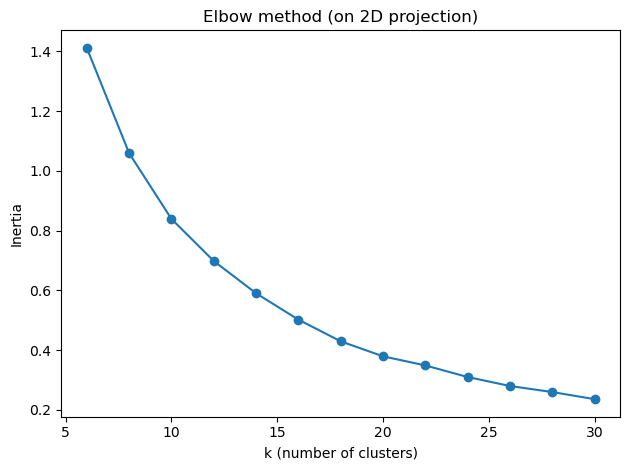

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ks = list(range(6, 31, 2))
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    # use reduced space to speed up & denoise
    km.fit(X_2d)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(ks, inertias, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow method (on 2D projection)")
plt.tight_layout()
plt.show()

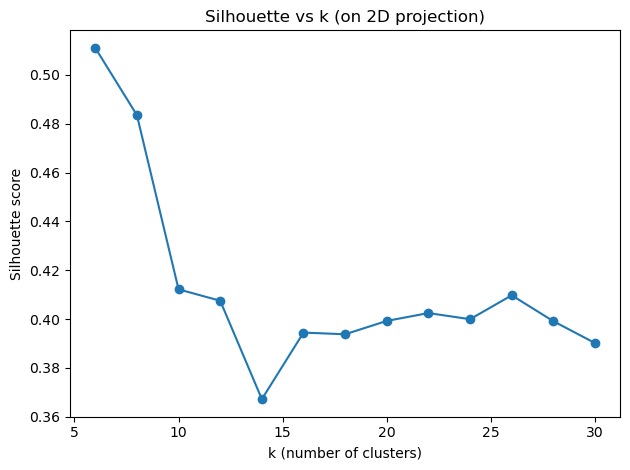

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = list(range(6, 31, 2))
sils = []
for k in ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = km.fit_predict(X_2d)
    sil = silhouette_score(X_2d, labels, random_state=42)
    sils.append(sil)

plt.figure()
plt.plot(ks, sils, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs k (on 2D projection)")
plt.tight_layout()
plt.show()

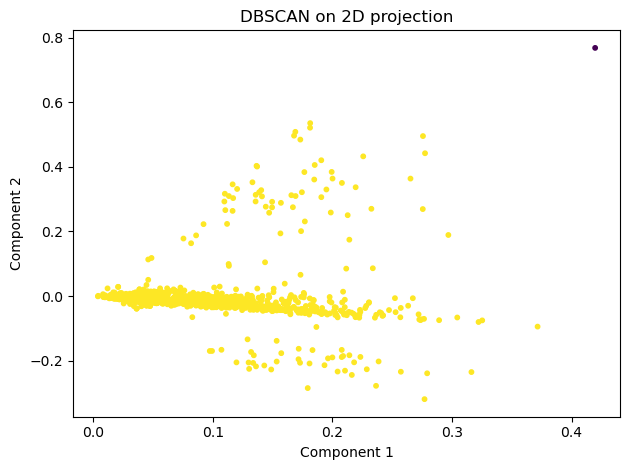

In [93]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.12, min_samples=5)  # tune eps if needed
labels_db = db.fit_predict(X_2d)

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_db, s=10)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("DBSCAN on 2D projection")
plt.tight_layout()
plt.show()

In [94]:
def detailed_dendrogram(X_2d, sample_size=120, method="ward",
                        seed=42, save=False, path="dendrogram_detailed.png"):
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(X_2d), size=min(sample_size, len(X_2d)), replace=False)
    Z = linkage(X_2d[idx], method=method)

    plt.figure(figsize=(14, 5.5))
    ax = plt.gca()
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    ct = 0.7 * Z[:, 2].max()
    dendrogram(
        Z,
        no_labels=True,
        count_sort="descending",
        color_threshold=ct,
        leaf_rotation=90.,           # if you later add labels
        leaf_font_size=8.
    )
    plt.title(f"Agglomerative clustering (Ward) — detailed, sample={len(idx)}")
    plt.xlabel("Leaves")
    plt.ylabel("Distance")
    plt.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.5)
    plt.tight_layout()
    if save:
        plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()

# optional:
# detailed_dendrogram(X_2d, sample_size=120, method="ward", save=False)

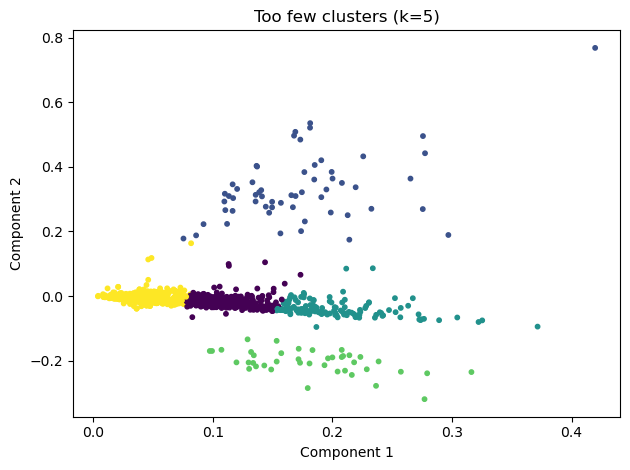

In [95]:
# Too few clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

km_few = KMeans(n_clusters=5, init="k-means++", n_init=10, random_state=42)
lab_few = km_few.fit_predict(X_2d)

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=lab_few, s=10)
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.title("Too few clusters (k=5)")
plt.tight_layout(); plt.show()

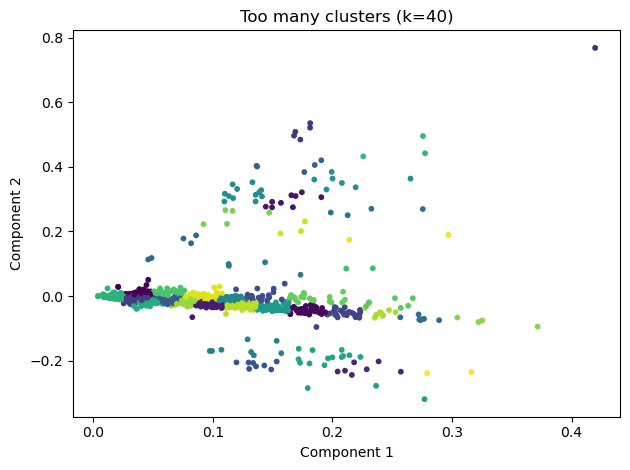

In [96]:
# Too many clusters
km_many = KMeans(n_clusters=40, init="k-means++", n_init=10, random_state=42)
lab_many = km_many.fit_predict(X_2d)

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], c=lab_many, s=10)
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.title("Too many clusters (k=40)")
plt.tight_layout(); plt.show()

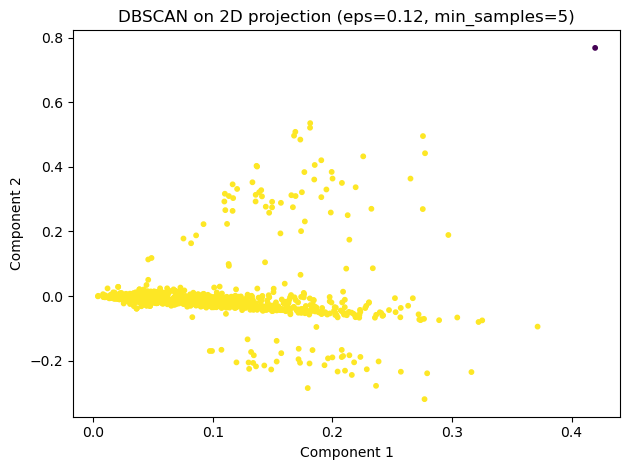

Clusters (including -1=noise): {np.int64(-1): np.int64(1), np.int64(0): np.int64(998)}


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def dbscan_demo(X_2d, eps=0.12, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_2d)
    plt.figure()
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=10)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(f"DBSCAN on 2D projection (eps={eps}, min_samples={min_samples})")
    plt.tight_layout()
    plt.show()
    uniq, counts = np.unique(labels, return_counts=True)
    print("Clusters (including -1=noise):", dict(zip(uniq, counts)))

dbscan_demo(X_2d, eps=0.12, min_samples=5)

In [159]:
# app.py
import numpy as np
import pandas as pd
import streamlit as st
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# Page config
# ----------------------------
st.set_page_config(
    page_title="Book Recommendation System",
    page_icon="📚",
    layout="wide"
)

st.title("📚 Book Recommendation System")
st.caption("Find books similar to your favorite title (based on title, author, genre).")

# ----------------------------
# Data & model (cached)
# ----------------------------
@st.cache_data
def load_data() -> pd.DataFrame:
    df = pd.read_csv("data/books_clean.csv")
    # normalize lowercase title for fast lookup (kept only in memory)
    df["title_norm"] = df["title"].str.lower().str.strip()
    return df

@st.cache_resource
def build_vectorizer(df: pd.DataFrame):
    corpus = (df["title"].fillna("") + " " +
              df["author"].fillna("") + " " +
              df["genre"].fillna(""))
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X = tfidf.fit_transform(corpus)
    title_to_idx = {t: i for i, t in enumerate(df["title_norm"])}
    return tfidf, X, title_to_idx

df = load_data()
tfidf, X, title_to_idx = build_vectorizer(df)

# ----------------------------
# Recommender
# ----------------------------
def recommend_by_title(
    title: str,
    top_k: int = 10,
    genre_filter: str | None = None
) -> pd.DataFrame:
    """Return up to top_k most similar books to the given title."""
    q = (title or "").lower().strip()
    if q not in title_to_idx:
        # fallback: contains search
        cand = df[df["title_norm"].str.contains(q, na=False)]
        if cand.empty:
            return df.iloc[0:0][["title", "author", "genre", "similarity"]]
        q = cand.iloc[0]["title_norm"]

    idx = title_to_idx[q]
    sims = cosine_similarity(X[idx], X).ravel()

    # exclude the query itself
    sims[idx] = -1.0

    # take a larger pool first, then post-filter & cut to top_k
    pool_idx = np.argsort(-sims)[: top_k * 3]
    res = df.iloc[pool_idx][["title", "author", "genre"]].copy()
    res["similarity"] = np.round(sims[pool_idx], 3)

    # keep only positive similarities
    res = res[res["similarity"] > 0]

    # optional genre filter
    if genre_filter and genre_filter != "All":
        res = res[res["genre"] == genre_filter]

    # final top_k
    res = res.sort_values("similarity", ascending=False).head(top_k)
    return res.reset_index(drop=True)

# ----------------------------
# UI controls
# ----------------------------
left, right = st.columns([2, 1])

with left:
    title_input = st.selectbox(
        "Choose a book title",
        options=sorted(df["title"].unique().tolist()),
        index=None,
        placeholder="Start typing a title..."
    )

with right:
    top_k = st.slider("Number of recommendations", min_value=3, max_value=20, value=10, step=1)

genre_choice = st.selectbox(
    "Optional: filter by genre",
    options=["All"] + sorted(df["genre"].dropna().unique().tolist())
)

go = st.button("✅ Recommend books", use_container_width=False)

# ----------------------------
# Results
# ----------------------------
if go:
    if not title_input:
        st.warning("Please choose a title first.")
    else:
        recs = recommend_by_title(title_input, top_k=top_k, genre_filter=genre_choice)
        if recs.empty:
            st.warning("No matches found. Try another title or remove the genre filter.")
        else:
            # Pretty table (rounded similarity)
            st.dataframe(
                recs.style.format({"similarity": "{:.3f}"}),
                use_container_width=True,
                hide_index=True
            )
            # Download button
            csv = recs.to_csv(index=False).encode("utf-8")
            st.download_button(
                "⬇️ Download recommendations (CSV)",
                data=csv,
                file_name="recommendations.csv",
                mime="text/csv"
            )

# ----------------------------
# Dataset stats
# ----------------------------
with st.expander("📊 Dataset stats", expanded=False):
    st.write(
        f"Rows: **{len(df)}** | Unique authors: **{df['author'].nunique()}** | "
        f"Unique genres: **{df['genre'].nunique()}**"
    )
    st.write(f"Unknown authors %: **{(df['author'] == 'Unknown').mean():.2%}**")

    # Top-10 genres (bar chart)
    top_genres = df["genre"].value_counts().head(10).sort_values(ascending=True)
    st.bar_chart(top_genres)

2025-08-21 18:28:17.297 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 18:28:17.300 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 18:28:17.300 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 18:28:17.301 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 18:28:17.303 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 18:28:17.303 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 18:28:17.304 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 18:28:17.304 No runtime found, using MemoryCacheStorageManager
2025-08-21 18:28:17.331 Thread 'MainThread':

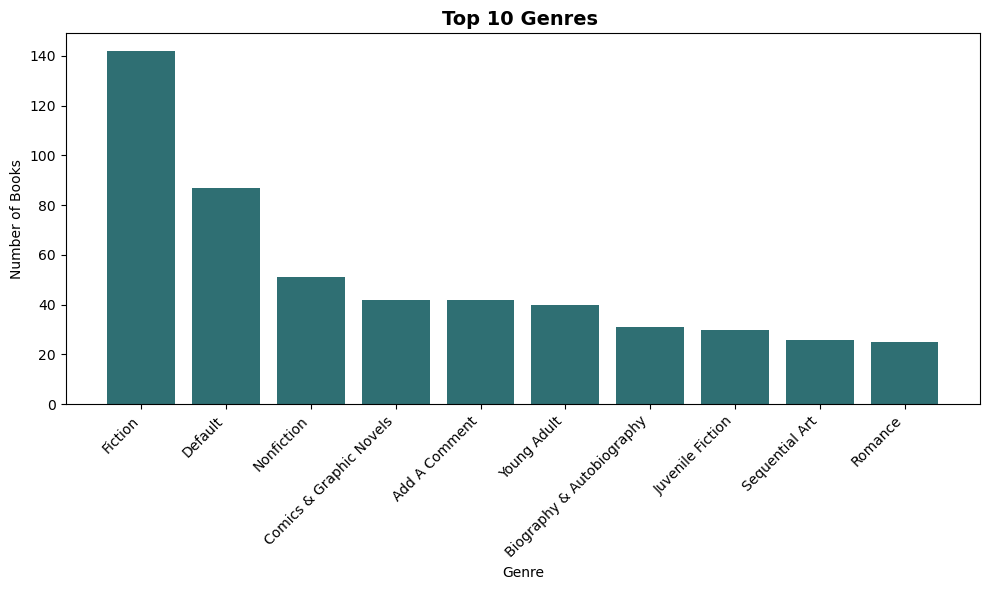

In [ ]:
import matplotlib.pyplot as plt


genre_counts = df['genre'].value_counts().head(10)

plt.figure(figsize=(10,6))
bars = plt.bar(genre_counts.index, genre_counts.values, color="#2F6F73")  
plt.title("Top 10 Genres ", fontsize=14, weight="bold")
plt.xlabel("Genre")
plt.ylabel("Number of Books")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [157]:
import matplotlib.pyplot as plt

def render_bar_table(df, filename="bar_table.png"):
    plt.figure(figsize=(8, 5))

    # horizontal bar chart
    bars = plt.barh(df['author'], df['similarity'] * 100,
                    color="#117A65")  # teal-green color

    # add percentage labels
    for bar, sim in zip(bars, df['similarity'] * 100):
        plt.text(bar.get_width() + 0.3,
                 bar.get_y() + bar.get_height()/2,
                 f"{sim:.1f}%",
                 va='center')

    # remove spines and x-axis ticks
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_visible(False)

    plt.title("Top Recommended Books")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.savefig(filename, dpi=200, bbox_inches="tight", transparent=True)
    plt.show()
    print(f"Saved → {filename}")

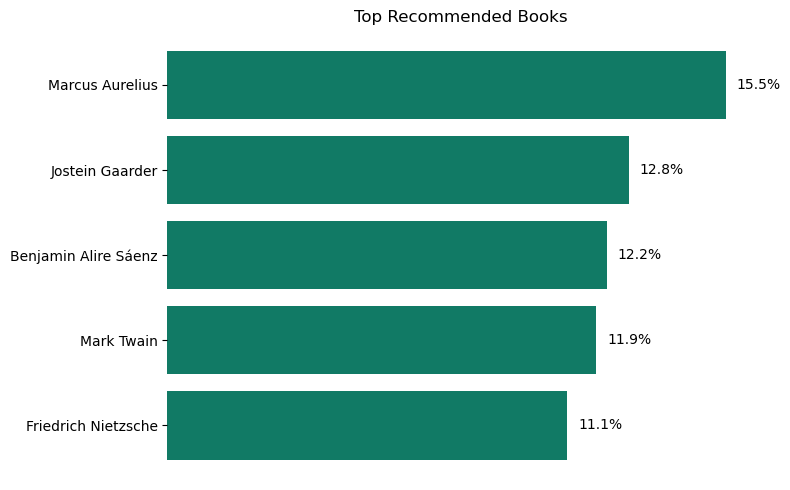

Saved → bar_table.png


In [158]:
query_title = "The Nicomachean Ethics"
top_k = 5
tbl = recommend_with_scores(query_title, top_k=top_k)

render_bar_table(tbl, filename="bar_table.png")